In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.gaussian_process.kernels import RBF


# Useful Methods
### What you see in this section:
1. function *integrate*, taking as input x-values and f(x)-values as lists, giving as output an estimate of the integral $$\int_{T}f(t)dt.$$ 
>Note that the accuracy of the estimation is largely impacted by the discretization step used in *T*.
2. function *proj*, taking as input the kernel K, the interval of interest T, the interval T0 where we want a generic funtion to be null, and the function f. It outputs the projection of f into the space H0, where functions are null along T0
>Note: it outputs also the error done in solving the linear system, usually large depending on K.
>Note: the method is not used in the rest of the code.
3. function *get_K0*, taking as input the kernel K, the interval of interest T, the interval T0 where we want a generic funtion to be null. It outputs the kernel K0 of H0, i.e. the kernel of the subspace H0 of function null along T0.

In [2]:
def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def proj(K,T,T0,f): #returns error and projection
    up_idx = int(np.where(T==T0[-1])[0])
    dw_idx = int(np.where(T==T0[0])[0])
    K_tau_tau = K[dw_idx:up_idx,dw_idx:up_idx]
    K_tau = K[dw_idx:up_idx,:]
    beta_tau = f[dw_idx:up_idx] 
    
    a = np.linalg.solve(np.linalg.inv(K_tau_tau),beta_tau)
    error = np.dot(a,K_tau_tau)-beta_tau
    proj = f-np.dot(a,K_tau)
    
    return error, proj

def get_K0(K,T,T0):
    up_idx = int(np.where(T==T0[-1])[0])
    dw_idx = int(np.where(T==T0[0])[0])
    K_tau_tau = K[dw_idx:up_idx,dw_idx:up_idx]
    K_tau = K[dw_idx:up_idx,:]
    
    return K - np.dot(np.dot(K_tau.T,np.linalg.inv(K_tau_tau)),K_tau)

### Methods usage

In [3]:
# integrate method
x_ex = np.linspace(0,np.pi,100)
f_ex = np.sin(x_ex)

integrate(x_ex,f_ex)

1.9998321638939935

> Note: with an RKHS with identity matrix as kernel, projections are not smooth at all, but it works well.

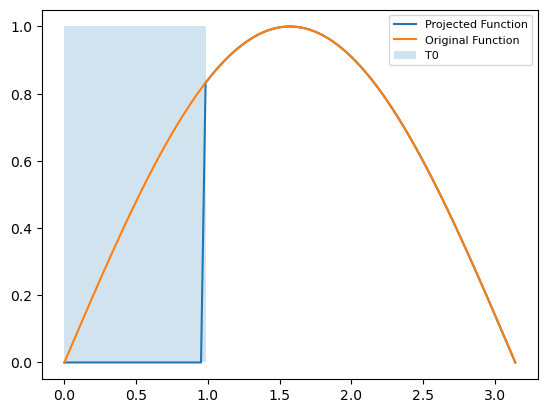

In [4]:
# proj method
K_ex = np.eye(100)
T0_ex = x_ex[np.where(x_ex<1)]

error_ex, proj_ex = proj(K_ex, x_ex, T0_ex, f_ex)
plt.plot(x_ex, proj_ex, label = 'Projected Function')
plt.plot(x_ex, f_ex, label = 'Original Function')
plt.fill_betweenx(y=[0, 1], x1 = T0_ex[0], x2 = T0_ex[-1],alpha=0.2,label='T0')
plt.legend(loc='upper right', fontsize=8)

# Synthetic Dataset Generation
### What you see in this section:
Definition of the Class "data_generator", using the following input

1. *T*, interval of interest, discretized, as a list
2. *T0*, a subset of T where the actual functional parameter has to be null
3. *beta*, the actual functional parameter, as a list of values
4. *n*, the number of functional covariates
5. *covariates_kernel*, the kernel of the functional covariates
6. *sigma*, the variance of the noise term in the regression model,

containing the function *i_o*, which return as output
1. *x*, a $n\times g$ np.array storing the covariates values
2. *y*, the actual scalar response, estimated by perturbating the true value obtained by means of the regression model.

In [5]:
class data_generator:
    def __init__(self, T, beta, n, covariates_kernel, sigma):
        self.T = T
        self.g = len(self.T)
        self.K = np.fromfunction(np.vectorize(lambda s, t: covariates_kernel(self.T[s], self.T[t])), (g, g), dtype=int)
        self.g = g
        self.n = n
        self.beta = beta
        self.sigma = sigma
    
    def i_o(self):
        x = np.random.multivariate_normal(np.zeros(self.g), self.K, self.n)
        y = np.fromfunction(np.vectorize(lambda i: integrate(self.T,  x[i,:]*beta)+np.random.normal(0,self.sigma,1)), (self.n,), dtype=int)
        return x,y

### We simulated a dataset with the following features:
1. $T=[-3,3].$
2. $T_{0} = [-1,0.5].$
3. Actual functional parameter $$\beta_{t} = \sin (\frac{\pi}{4}t).$$
4. Centered gaussian covariates $x_{i}$ with $i\in\{1,...,100\}$ with kernel $$k_{x}(s,t)=e^{-2(t-s)^{2}}.$$
5. Scalar response $y_{i}$ according to the regression model, perturbated with $\epsilon_{i}\sim N[0,\sigma^{2}].$

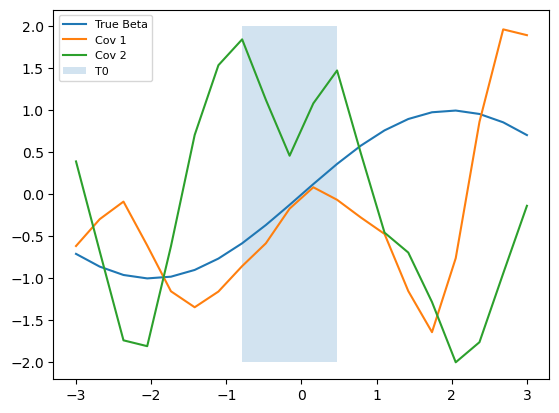

In [6]:
# EXAMPLE
# input
a = -3
b = 3
g = 20
T = np.linspace(a,b,g)
T0 = T[np.where((T<0.5)&(T>-1))]
n = 100
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)

#generation
data = data_generator(T,beta,n,covariates_kernel, sigma)
x,y = data.i_o()

plt.plot(T,beta,label='True Beta')
plt.plot(T,x[0,:],label='Cov 1')
plt.plot(T,x[1,:],label='Cov 2')
plt.fill_betweenx(y=[-2, 2], x1 = T0[0], x2 = T0[-1],alpha=0.2,label='T0')
plt.legend(fontsize=8)

> IMPORTANT! 
> The prior kernel is a very critical issue. We found out the following facts:
1. With a small g (i.e. a bigger step in storing tha value of function, calculating integrals etc) and a gaussian kernel we have: prior covariance PositiveSemiDef, posterior covariance NOT PositiveSemiDef, a good fit 
2. With a large g and a gaussian kernel we have: prior covariance NOT PositiveSemiDef, posterior covariance NOT PositiveSemiDef, a bad fit
3. With a large g and a gaussian kernel but with perturbations on the diagonal of the prior covariance matrix (in this case +1) we have: prior covariance PositiveSemiDef, posterior covariance NOT PositiveSemiDef, a good fit.

> We invite you to try both version of the prior kernel: *prior_kernel* and *prior_kernel_pert*.

In [7]:
def prior_kernel(s,t):
    return np.exp(-2*((t-s)**2))

def prior_kernel_pert(s,t):
    return np.exp(-((t-s)**2))+1*(s==t)

K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int)
#K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel_pert(T[s], T[t])), (g, g), dtype=int)

np.all(np.linalg.eigvals(K)>=0) #check PSDness

True

# Posterior Mean and Covariance
### What you see in this section:
The class *Posterior* returns the constrained model outcomes thanks to the functions
1. *posterior_mean_cov*, returning the posterior mean and covariance
2. *fitted_values*, returning the values $\hat{y}$ predicted by the constrained model

In [8]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = integrate(self.T,self.K0[t, :] * self.x[i,:])
        return L
    
    def R0(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: integrate(self.T,self.K0[:,t] * self.x[i,:])), (self.g,), dtype=int)
        Rij = integrate(self.T, Ri * self.x[j,:])
        return  Rij
    
    def M(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R0(i, j)), (self.n, self.n), dtype=int)+np.identity(self.n)
    
    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: integrate(self.T, self.x[i,:]*m)), (self.n,), dtype=int)


In [9]:
# EXAMPLE
p = posterior(T,T0,x,y,K,sigma)
m, cov = p.posterior_mean_cov()

> Note that the covariance function could be not simmetric, due to approximations. We are considering to impose $K^{*}=K^{* T}$, since the elementwise difference is usually small ($K^{*}[i,j]-K^{*}[j,i]\approx 10^{-15}$).

In [10]:
np.all(np.linalg.eigvals(cov) >= 0) #check PSDness

False

# Goodness Check

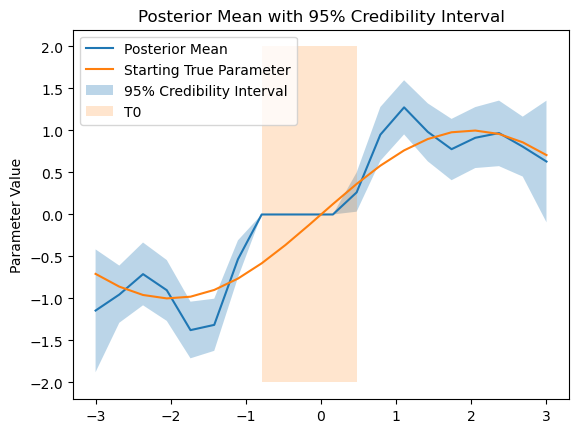

In [12]:
samples = np.random.multivariate_normal(m, cov, size=10000)

up = np.zeros(m.shape[0])
down = np.zeros(m.shape[0])

for i in range(m.shape[0]):
    up[i]=np.quantile(samples[:,i],0.95)
    down[i]=np.quantile(samples[:,i],0.05)

plt.plot(T,m, label='Posterior Mean')
plt.plot(T,beta, label='Starting True Parameter')
plt.fill_between(T, down, up, alpha=0.3, label='95% Credibility Interval')
plt.fill_betweenx(y=[-2, 2], x1 = T0[0], x2 = T0[-1],alpha=0.2,label='T0')

plt.title('Posterior Mean with 95% Credibility Interval')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()